In [1]:
import os
import re
import nltk
import string
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from dateutil.relativedelta import relativedelta

from nltk import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /home/eggman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/eggman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def simplify_dates(datasetT):
    datasetT['Datetime'] = [datetime.datetime.strptime(re.sub('\+00:00','',i), date_format) for i in datasetT['Datetime']]
    return datasetT
    
def round_sentiments(datasetT):
    datasetT[['Negative','Neutral','Positive']] = np.rint(datasetT[['Negative','Neutral','Positive']])
    return datasetT

In [3]:
# This function imports the dataset and tidies up the sentiments a bit
def get_cleaned_df(file_read):
    dataset = pd.read_csv(file_read,lineterminator='\n')
    dataset = simplify_dates(dataset)
    dataset = round_sentiments(dataset)
    dataset = dataset.iloc[::-1].reset_index(drop=True)
    return dataset

In [4]:
# I found it easier to just have a single column with the sentiment associated to that tweet
def tidy_data(tweetdir,list_files):
    full_set = pd.concat([get_cleaned_df(tweet_dir + file) for file in list_files], ignore_index=True)
    full_set['Text'] = [re.sub('https.*','', line) for line in full_set['Text']]
    full_set = full_set.drop_duplicates(subset=['Text']).reset_index(drop=True)
    sentiment_column = np.full(len(full_set),'        ')
    sentiment_column[full_set['Negative'] == 1.0] = 'Negative'
    sentiment_column[full_set['Positive'] == 1.0] = 'Positive'
    sentiment_column[sentiment_column == '        '] = 'Neutral'
    full_set.insert(6, "Sentiment", sentiment_column, True)
    return(full_set)

In [5]:
tweet_dir = './data_tweets/'
date_format = '%Y-%m-%d %H:%M:%S'
list_files_raw = np.array(os.listdir(tweet_dir))
list_files = np.sort(list_files_raw[['un_mentions_processed' in file for file in list_files_raw]])
full_set = tidy_data(tweet_dir,list_files)

In [58]:
stop = set(stopwords.words('english') + list(string.punctuation))
stop.update(['’','https','un','amp',"'",'``',"''","'s",'..','...',"n't",'--','”','–','//','“','like','also','put',
             'ask','w/','unitednations'])

def clean_sentence(sentence):
    cleaned = list(dict.fromkeys([i for i in word_tokenize(sentence.lower()) if i not in stop]))
    return cleaned

start_date = full_set["Datetime"][0].date()
end_date = full_set["Datetime"][len(full_set)-1].date()
daterange = pd.date_range(start_date, end_date)
uq_list = []
top_w_list = set({})

for single_date in tqdm_notebook(daterange):
    words_List = [clean_sentence(text) for text in full_set[
        (full_set["Datetime"] < pd.to_datetime(single_date + datetime.timedelta(1))) &
        (full_set["Datetime"] >= pd.to_datetime(single_date))
    ]['Text']]
    uq_words, uq_count = np.unique(np.hstack(words_List), return_counts=True)
    uq_day = dict(zip(uq_words, uq_count))
    uq_list.append(uq_day)
    
    day_top = np.intersect1d(
        uq_words[np.argsort(uq_count)[-10:]],
        uq_words[uq_count >= 20]
    )
    top_w_list.update(day_top)
    
top_w_list = np.array(list(top_w_list))

  0%|          | 0/800 [00:00<?, ?it/s]

In [60]:
top_w_dyn = np.empty((len(top_w_list), len(uq_list)), int)

for w in tqdm_notebook(range(len(top_w_list))):
    top_dyn = np.array([])
    for i in range(len(uq_list)):
        try:
            top_dyn = np.append(top_dyn, uq_list[i][top_w_list[w]])
        except:
            top_dyn = np.append(top_dyn, 0)
    top_w_dyn[w] = top_dyn

  0%|          | 0/589 [00:00<?, ?it/s]

## Finding all trends: Hierarchical Clustering <a class="anchor" id="find-clustering"></a>
I then decide that while PCA worked well to get the biggest trends, in order to be thorough one must use a method to systematically find and cluster peaks.

For the first step I normalised the dynamics of the chosen keywords and kept only those that at any point in time were tweeted 25 times more than their usual median, or more than 100 times if their median was 0. This provided all the positions of what I would consider a peak or an above background amount of tweets.

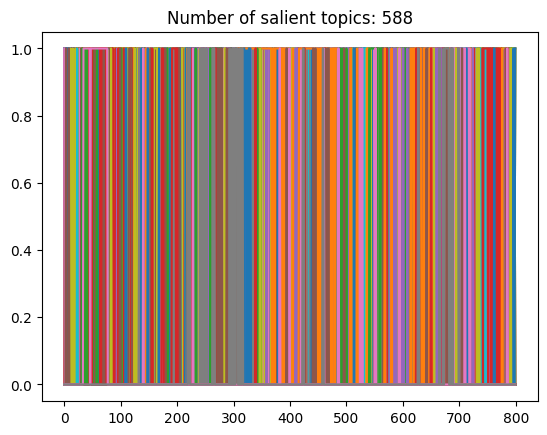

In [202]:
clipped_rows = np.array([np.ceil(np.clip(feature / max(np.median(feature), 1) - 5, 0, 1)) for feature in top_w_dyn])
peak_row_index = np.where(clipped_rows.sum(axis=1) != 0)[0]
peak_rows = clipped_rows[peak_row_index]
peak_row_names = top_w_list[peak_row_index]

plt.plot(peak_rows.T);
plt.title("Number of salient topics: "+str(len(peak_rows)));

In [203]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

## Topic lifetime (Random Forests)
In this section I explore how long keywords and clustered topic exist. Indeed I plot a comparison of how long a particular word stays "active" vs how many times it is tweeted in the analysed timeframe. One can observe there is indeed not a direct correlation, if anything it seems that topics either are tweeted in large quantities or over long periods of time but not both.

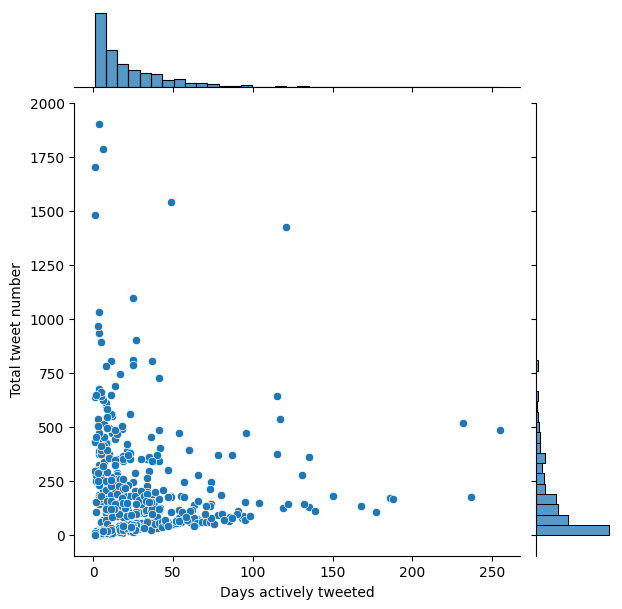

In [204]:
ax = sns.jointplot(x=np.sum(peak_rows,axis=1), y=np.sum(top_w_dyn[peak_row_index],axis=1)/24)
ax.set_axis_labels(xlabel="Days actively tweeted", ylabel="Total tweet number");

In [205]:
def get_bursts(burst_list, masked_list, normal_list):
    start_burst,end_burst = [],[]
    for i, val in enumerate(masked_list):
        if (masked_list[i] == 0) & (masked_list[i+1] > 0):
            start_burst.append(i+1)
        if (len(start_burst) > len(end_burst)) & (normal_list[i] <= 15) & (masked_list[i] == 0):
            end_burst.append(i+1)
    
    for i in range(len(end_burst)):
        burst_list.append(normal_list[start_burst[i]:end_burst[i]])
        
    return(burst_list)

In [224]:
clipped_rows[3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [245]:
def get_burst_SE(clipped_dyn):
    list_bursts = []
    for i in range(len(clipped_dyn)):
        if((clipped_dyn[i:i+3].sum() == 3) & (clipped_dyn[i-3:i].sum() == 0)):
            new_burst = np.array([i,0])
            for j in range(i, len(clipped_dyn)):
                if clipped_dyn[j:j+3].sum() == 0:
                    new_burst[1] = j
                    list_bursts.append(new_burst)
                    break

    list_bursts = np.array(list_bursts)
    return(list_bursts)

In [251]:
all_bursts_SE = [get_burst_SE(clip_r) for clip_r in clipped_rows]

In [256]:
all_bursts_SE

[array([], dtype=float64),
 array([[635, 643],
        [647, 652]]),
 array([[566, 571]]),
 array([[262, 268],
        [627, 631]]),
 array([], dtype=float64),
 array([[625, 631],
        [794, 797]]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([[261, 264],
        [272, 275]]),
 array([[ 50,  54],
        [100, 108],
        [601, 609],
        [635, 638],
        [652, 661]]),
 array([[503, 525],
        [529, 532],
        [556, 619],
        [622, 672],
        [683, 693],
        [782, 788],
        [795, 798]]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([[290, 301],
        [600, 608]]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([[416, 428],
        [627, 633],
        [636, 639]]),
 array([[319, 329]]),
 array([[425, 428]]),
 array([[419, 427]]),
 array([], dtype=float64),
 array([[581, 584],
        [657, 664]]),
 array([[303, 306]]),
 array([

In [177]:
def get_assym_split(vec):
    space_vec = len(vec)*np.array([1-1/(50-1)*(50**i-1) for i in np.arange(0,1,0.1)])
    return np.flip(np.round(space_vec)-1).astype(np.int16)

get_assym_split(np.zeros(72))

array([23, 39, 50, 57, 62, 65, 68, 69, 70, 71], dtype=int16)

In [178]:
min_split_size = 50
full_bursts = []
for (burst, acum_burst) in zip(burst_list, burst_acum_list):
    if len(burst) > min_split_size:
        num_sec = np.floor(np.log2(len(burst))).astype(np.int16)-2
        sec_size = np.floor(len(burst)/num_sec).astype(np.int16)
        for split in range(sec_size, len(burst)-num_sec, sec_size):
#             print(len(burst),num_sec,sec_size,split,len(burst[:-split]))
            training = np.concatenate([[len(burst[:-split])],
#                              [sec[-1] for sec in np.array_split(burst[:-split],10)],
#                              [sec[-1] for sec in np.array_split(acum_burst[:-split],10)],
                             [burst[sec] for sec in get_assym_split(burst[:-split])],
                             [acum_burst[sec] for sec in get_assym_split(acum_burst[:-split])],
                             [len(burst)]
                            ])
            full_bursts.append(training)

full_bursts = np.array(full_bursts)
print(len(full_bursts))

63


As I am looking at a wide range of timescales, the error will naturally get larger with greater timescales so it is natural to take the logarithm of the y data. I like taking log2 as I find it easier to read data when plotted than natural log. The data looks nicely distributed and ready to train.

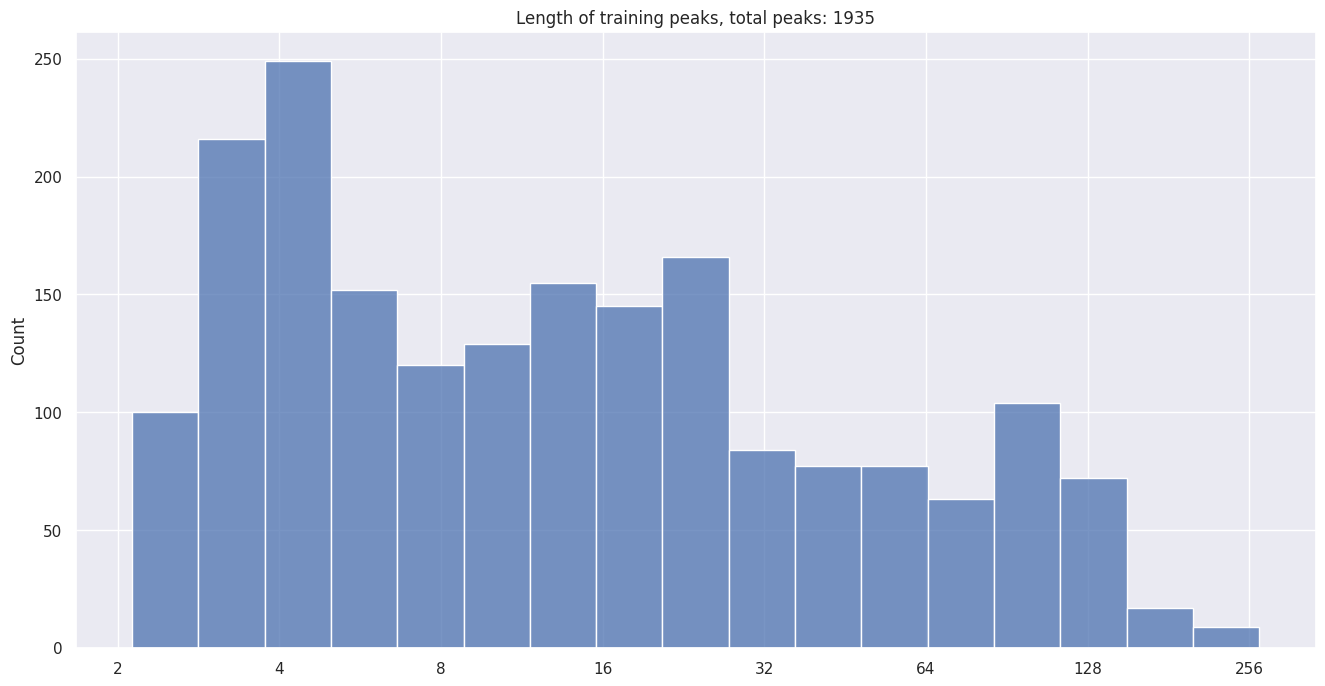

In [92]:
from sklearn.model_selection import train_test_split
X, y = full_bursts[:,:-1], full_bursts[:,-1]

y = y/24
y = np.log2(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
sns.set(rc = {'figure.figsize':(16,8)})
ax = sns.histplot(y);
ax.set_xticks(np.arange(1,9,1))
ax.set_xticklabels(np.exp2(np.arange(1,9,1)).astype(np.int16));
ax.set(title='Length of training peaks, total peaks: '+str(len(full_bursts)));

I tried many types of models, but in the end something relative simple worked. I have found the "ExtraTrees" subpackage from sklearn works quite well.

In [93]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(n_estimators=1000, random_state=42).fit(X_train, y_train)
print(reg.score(X_test, y_test))

0.8792623649616574


The regression score is reasonably good and the predictions for the test data look like a solid correlation as seen below, so one can have some decent confidence in this model. Of course when dealing with data depending on the news, things can change dramatically. Hopefully this model captures sufficient variability that this will not be a major issue.

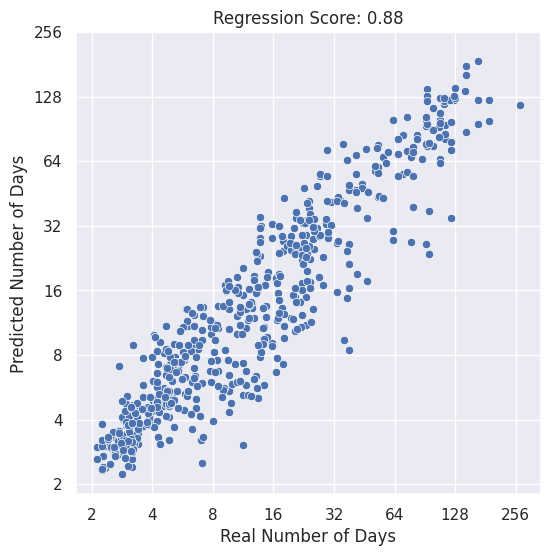

In [94]:
sns.set(rc = {'figure.figsize':(6,6)})
ax = sns.scatterplot(x=y_test,y=reg.predict(X_test));
ax.set(ylabel="Predicted Number of Days",xlabel="Real Number of Days",title="Regression Score: "+str(np.round(reg.score(X_test, y_test),2)));
ax.set_xticks(np.arange(1,9,1))
ax.set_xticklabels(np.exp2(np.arange(1,9,1)).astype(np.int16));
ax.set_yticks(np.arange(1,9,1))
ax.set_yticklabels(np.exp2(np.arange(1,9,1)).astype(np.int16));

In [95]:
ongoing_full_bursts = []
for (burst, acum_burst) in zip(ongoing_burst_list, ongoing_burst_acum_list):
    if len(burst) > 24:
        training = np.concatenate([[len(burst)],
#                         [sec[-1] for sec in np.array_split(burst,10)],
#                         [sec[-1] for sec in np.array_split(acum_burst,10)]
                        [burst[sec] for sec in get_assym_split(burst)],
                        [acum_burst[sec] for sec in get_assym_split(acum_burst)]
                        ])
        ongoing_full_bursts.append(training)

ongoing_full_bursts = np.array(ongoing_full_bursts)

In [96]:
minLen_index =[ongoing_burst_index[i] for i in range(len(ongoing_burst_list)) if len(ongoing_burst_list[i]) > 24]
ongoing_top_words = pd.DataFrame([peak_row_names[minLen_index],
    np.array([len(burst)/24 for burst in ongoing_burst_list if len(burst) > 24]),
    np.exp2(reg.predict(ongoing_full_bursts))]).transpose()
ongoing_top_words.columns = ["Word","Current Duration","Predicted Lifetime"]

In [97]:
melted_ongoing_top_words = ongoing_top_words.melt(id_vars='Word', var_name="Keys", value_name="Days")
melted_ongoing_top_words["Days"] = melted_ongoing_top_words["Days"].astype(np.float32)

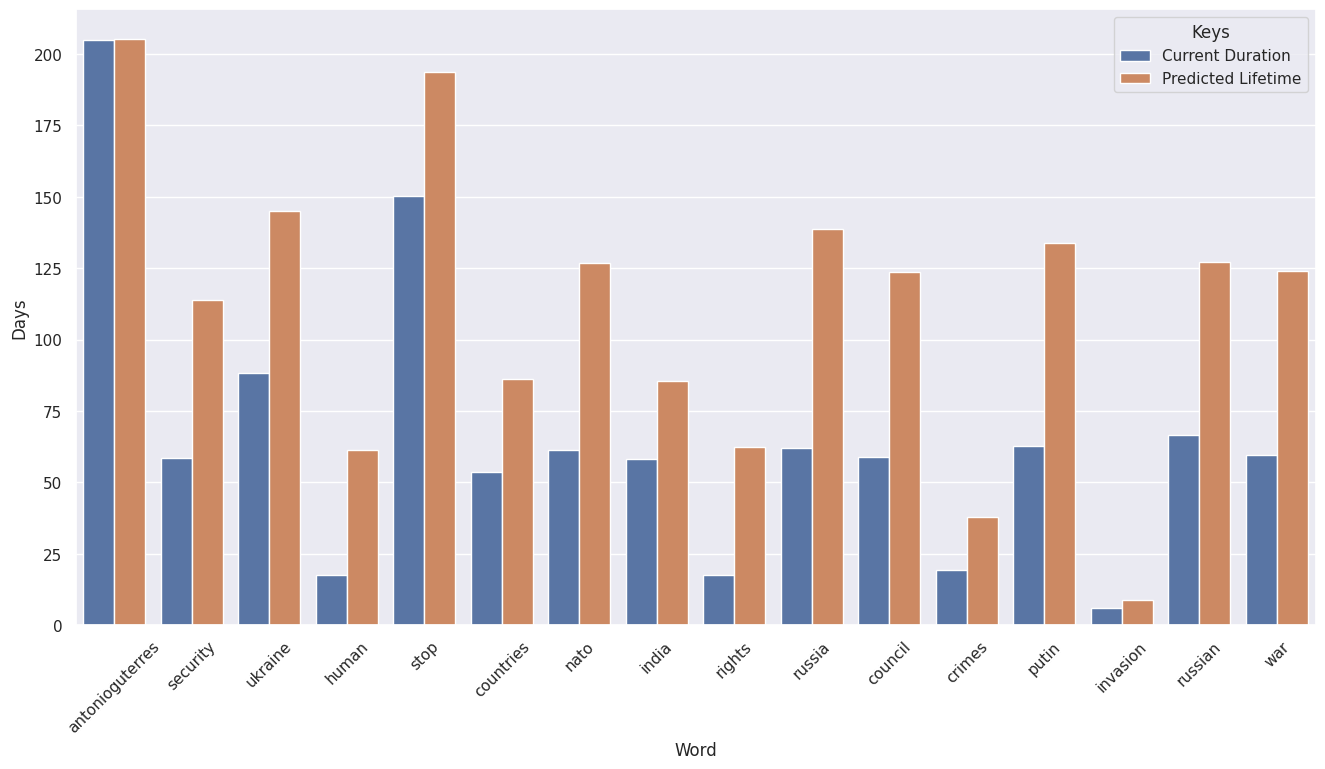

In [98]:
sns.set(rc = {'figure.figsize':(16,8)})
ix = sns.barplot(data = melted_ongoing_top_words, x= "Word", y= "Days", hue= "Keys");
plt.xticks(rotation=45);